# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [ ] Solve problem with accuracy
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )

## Install TabPFN offline

In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [2]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [4]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [5]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

  0%|          | 0/56 [00:00<?, ?it/s]

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [6]:
def preprocess(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    woes = dict()
    numeric_features = stats[stats.logloss.notna()].index.tolist() # Cause for EJ logloss is null
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train_out[i], y=train_out['Class'])
        train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
        test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
        out_features.append(i + '_WoE')
        woes[i] = tmp_woe
    
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features, woes


train_out,test_out,features, woes = preprocess(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

In [7]:
basic_stats_2 = compute_basic_stats(
    columns=[i for i in train_out.columns if i not in ["Id","Class"]],         
    df=train_out)

basic_stats_2

  0%|          | 0/121 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU_WoE,4,0.0,float64,-0.52,-2.678782,2.977892,1.042059,0.286027,4.790242
FL_WoE,4,0.0,float64,-0.42,-2.045013,2.977892,0.86161,0.214552,5.374418
DI_WoE,3,0.0,float64,-0.37,-2.361247,0.382521,0.698812,0.124925,5.432836
DA_WoE,3,0.0,float64,-0.37,-2.093932,0.463416,0.719046,0.14452,5.549671
GL_WoE,4,0.0,float64,-0.4,-1.805209,2.977892,0.865805,0.230269,5.783341
FD_WoE,3,0.0,float64,-0.33,-1.996604,0.379845,0.635814,0.115675,5.783341
EH_WoE,3,0.0,float64,-0.32,-2.061142,0.343225,0.622624,0.111704,5.841759
EH,127,0.0,float64,0.18,-0.1635,22.876681,1.0,-0.0,5.900177
AM,605,0.0,float64,0.24,-0.513293,8.483647,1.0,0.0,5.900177
BC_WoE,3,0.0,float64,-0.3,-1.9811,0.486565,0.630381,0.116679,5.900177


# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [47]:
def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    # Names of columns
    submition_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            # into TensorFlow Datasets format (tf.data.Dataset).
            train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_ds, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            out_of_fold.loc[valid_ids, 0] = model.predict(x=valid_ds).flatten()
            submition[i] = model.predict(x=submition_ds).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=train_ds,return_dict=True)
            train_metric = evaluation["balanced_logloss_tf"]
            
            evaluation = model.evaluate(x=valid_ds,return_dict=True)
            val_metric = evaluation["balanced_logloss_tf"]
            
            # Plot Results
            plot_train_logs(model)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
         
    
            
    return submition,models,metrics

def balanced_logloss_tf(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = tf.reshape(K.log(y_pred_1),[-1,1])
    log_y_pred_0 = tf.reshape(K.log(y_pred_0),[-1,1])

    y_1 = tf.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
    logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

# RandomForestModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp32rw7v6g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.935165. Found 555 examples.
Training model...
Model trained in 0:00:00.701722
Compiling model...


[INFO 23-07-20 08:49:33.9245 UTC kernel.cc:1242] Loading model from path /tmp/tmp32rw7v6g/model/ with prefix b66312f0db554479
[INFO 23-07-20 08:49:34.0405 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34210 node(s), and 113 input feature(s).
[INFO 23-07-20 08:49:34.0406 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:49:34.0406 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 361ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2942


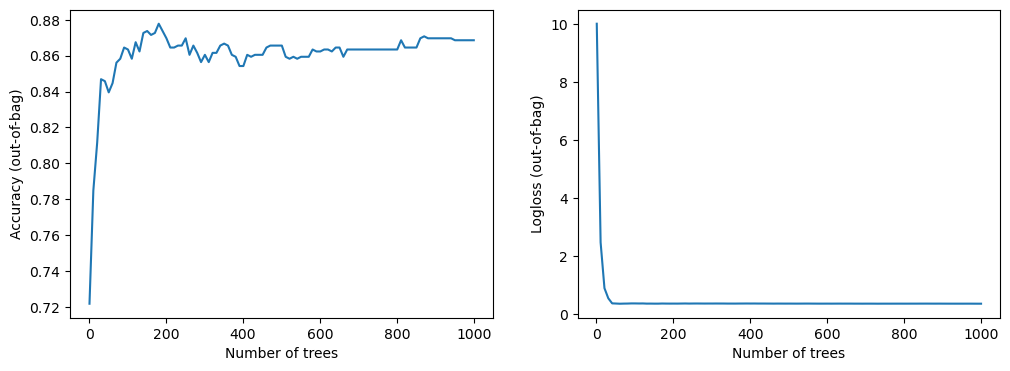


Train: 0.1816 Validation: 0.2942
##### Fold 2
Use /tmp/tmpiwlqh74v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.927981. Found 555 examples.
Training model...
Model trained in 0:00:00.705678
Compiling model...


[INFO 23-07-20 08:49:41.2478 UTC kernel.cc:1242] Loading model from path /tmp/tmpiwlqh74v/model/ with prefix dfa65b46b97b49d7
[INFO 23-07-20 08:49:41.3644 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34512 node(s), and 113 input feature(s).
[INFO 23-07-20 08:49:41.3645 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 369ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3145


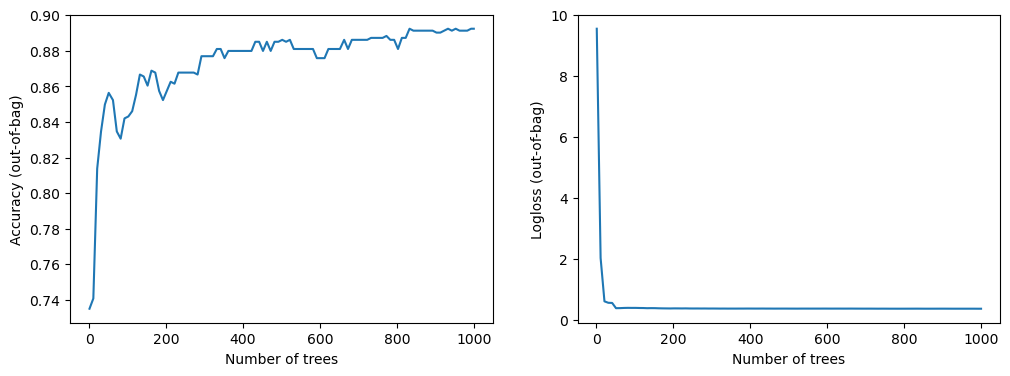


Train: 0.1801 Validation: 0.3145
##### Fold 3
Use /tmp/tmpcdro9q1r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.936282. Found 555 examples.
Training model...
Model trained in 0:00:00.707473
Compiling model...


[INFO 23-07-20 08:49:48.4871 UTC kernel.cc:1242] Loading model from path /tmp/tmpcdro9q1r/model/ with prefix c2f0123d81834757
[INFO 23-07-20 08:49:48.6045 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34332 node(s), and 113 input feature(s).
[INFO 23-07-20 08:49:48.6046 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:49:48.6046 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 350ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4360


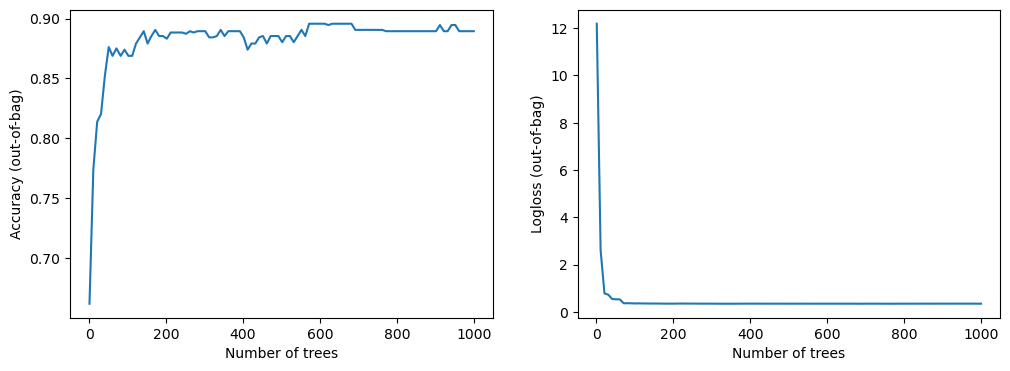


Train: 0.1718 Validation: 0.4360
##### Fold 4
Use /tmp/tmprb8wysjz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.973700. Found 555 examples.
Training model...
Model trained in 0:00:00.700286
Compiling model...


[INFO 23-07-20 08:49:54.9281 UTC kernel.cc:1242] Loading model from path /tmp/tmprb8wysjz/model/ with prefix 9270d2bc9c8c4c80
[INFO 23-07-20 08:49:55.0454 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34210 node(s), and 113 input feature(s).
[INFO 23-07-20 08:49:55.0455 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 367ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3325


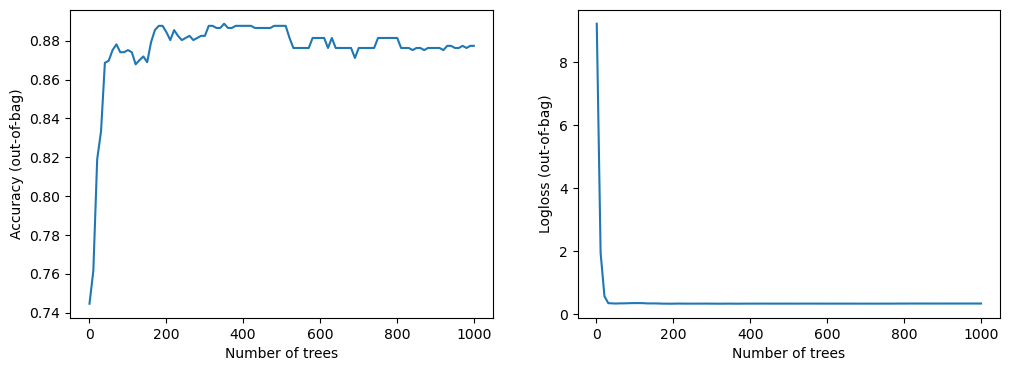


Train: nan Validation: 0.3325
##### Fold 5
Use /tmp/tmp4ru83prk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.926885. Found 555 examples.
Training model...
Model trained in 0:00:00.706852
Compiling model...


[INFO 23-07-20 08:50:01.3671 UTC kernel.cc:1242] Loading model from path /tmp/tmp4ru83prk/model/ with prefix 91fdf1b40e0c494e
[INFO 23-07-20 08:50:01.4832 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34614 node(s), and 113 input feature(s).
[INFO 23-07-20 08:50:01.4832 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:50:01.4833 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 357ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3191


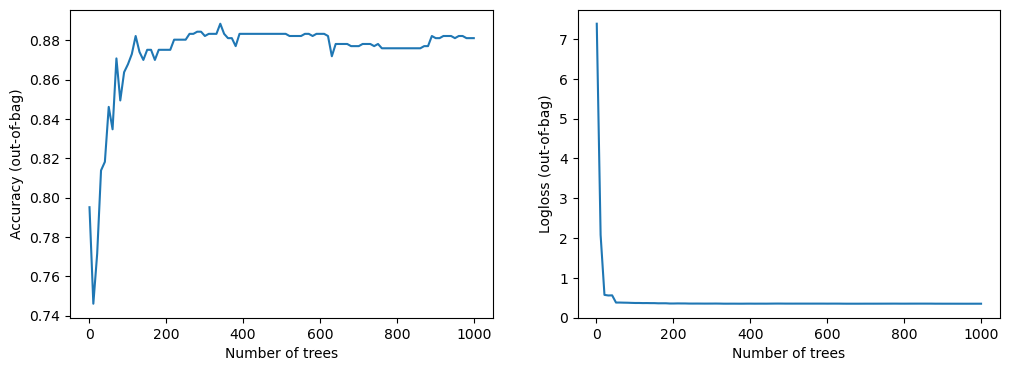


Train: 0.1753 Validation: 0.3191
##### Fold 6
Use /tmp/tmpypq8r8ui as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.957985. Found 555 examples.
Training model...
Model trained in 0:00:00.700537
Compiling model...


[INFO 23-07-20 08:50:08.6641 UTC kernel.cc:1242] Loading model from path /tmp/tmpypq8r8ui/model/ with prefix 8ed31414c8104216
[INFO 23-07-20 08:50:08.7785 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34414 node(s), and 113 input feature(s).
[INFO 23-07-20 08:50:08.7785 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 358ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3483


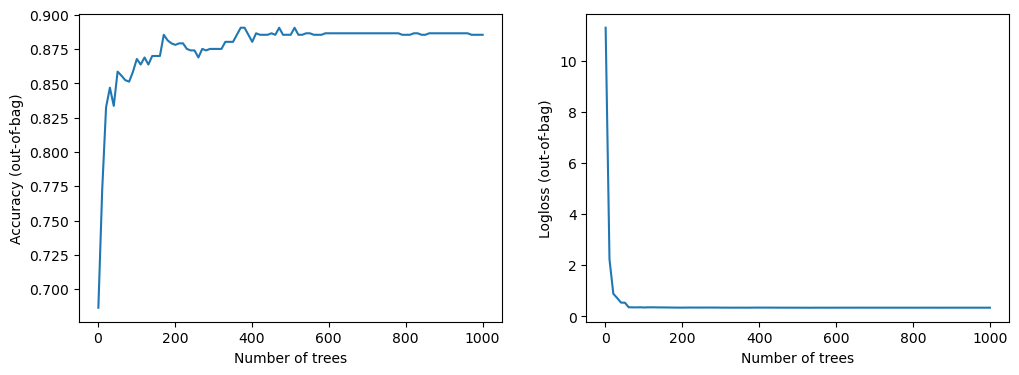


Train: 0.1722 Validation: 0.3483
##### Fold 7
Use /tmp/tmp9jg85d4w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.927939. Found 555 examples.
Training model...
Model trained in 0:00:00.703286
Compiling model...


[INFO 23-07-20 08:50:15.0831 UTC kernel.cc:1242] Loading model from path /tmp/tmp9jg85d4w/model/ with prefix de2eea8bc39e4c08
[INFO 23-07-20 08:50:15.1997 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34550 node(s), and 114 input feature(s).
[INFO 23-07-20 08:50:15.1997 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:50:15.1998 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 342ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3973


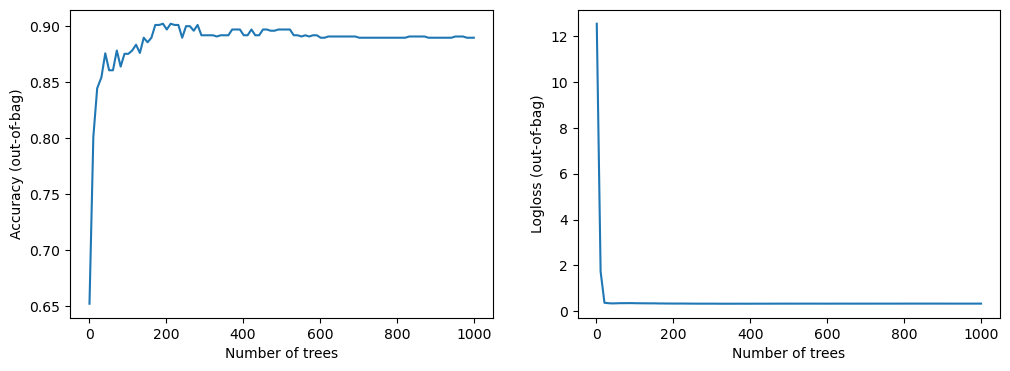


Train: 0.1711 Validation: 0.3973
##### Fold 8
Use /tmp/tmp3lcmrpwm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.904519. Found 556 examples.
Training model...
Model trained in 0:00:00.703756
Compiling model...


[INFO 23-07-20 08:50:21.6019 UTC kernel.cc:1242] Loading model from path /tmp/tmp3lcmrpwm/model/ with prefix 0e6e7ef4cb1249b8
[INFO 23-07-20 08:50:21.7168 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34432 node(s), and 113 input feature(s).
[INFO 23-07-20 08:50:21.7171 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 360ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3383


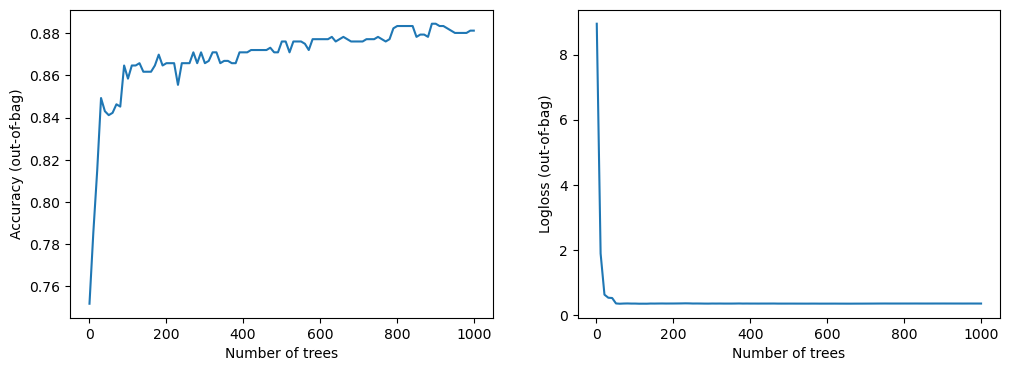


Train: 0.1769 Validation: 0.3383
##### Fold 9
Use /tmp/tmp0zd4n91e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.928833. Found 556 examples.
Training model...
Model trained in 0:00:00.697547
Compiling model...


[INFO 23-07-20 08:50:28.0318 UTC kernel.cc:1242] Loading model from path /tmp/tmp0zd4n91e/model/ with prefix 668e960de6b9401c
[INFO 23-07-20 08:50:28.1480 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34142 node(s), and 113 input feature(s).
[INFO 23-07-20 08:50:28.1483 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:50:28.1484 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 350ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3867


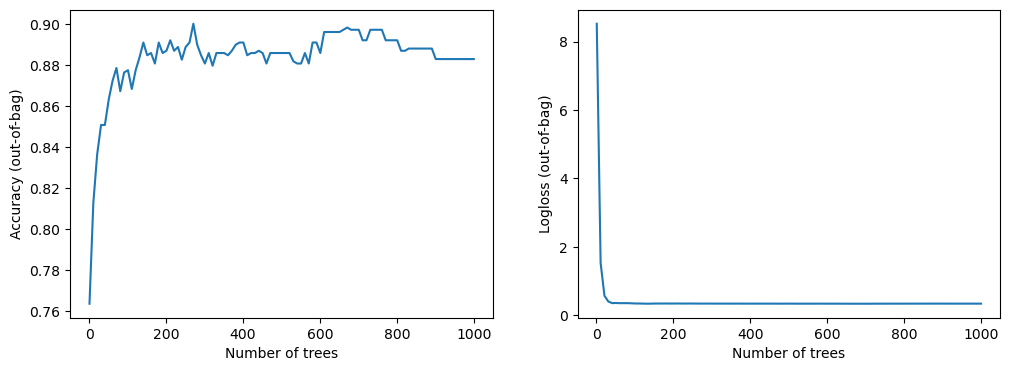


Train: 0.1734 Validation: 0.3867
##### Fold 10
Use /tmp/tmp58uvwhbh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.905489. Found 556 examples.
Training model...
Model trained in 0:00:00.714065
Compiling model...


[INFO 23-07-20 08:50:34.4391 UTC kernel.cc:1242] Loading model from path /tmp/tmp58uvwhbh/model/ with prefix 6532499944734045
[INFO 23-07-20 08:50:34.5591 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34820 node(s), and 113 input feature(s).
[INFO 23-07-20 08:50:34.5593 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 351ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2814


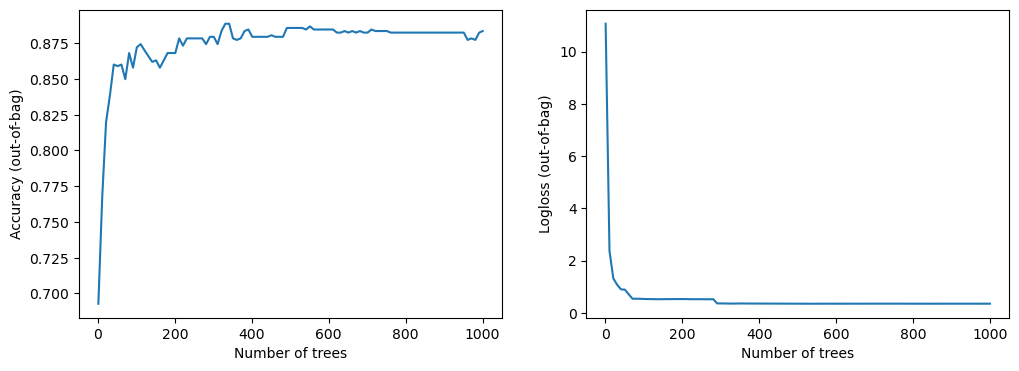


Train: 0.1784 Validation: 0.2814

Train mean: 0.1756 std: 0.0038

Validation mean: 0.3448 std: 0.0485


In [49]:
# RandomForestModel
submition_rf_1, model_rf_1,metrics_rf_1 = train_model(
    train=train_out,test=test_out, features=features,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpbqm8_g8r as temporary training directory
Reading training dataset...


/opt/conda/lib/python3.10/tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmpm_q6dgzd'>
  _warnings.warn(warn_message, ResourceWarning)
/opt/conda/lib/python3.10/tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmp476ac8a4'>
  _warnings.warn(warn_message, ResourceWarning)
/opt/conda/lib/python3.10/tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmpr27mkt0c'>
  _warnings.warn(warn_message, ResourceWarning)
/opt/conda/lib/python3.10/tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmpr5lmfepq'>
  _warnings.warn(warn_message, ResourceWarning)
/opt/conda/lib/python3.10/tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmpuzd7hoyf'>
  _warnings.warn(warn_message, ResourceWarning)
/opt/conda/lib/python3.10/tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/tmp/tmpwv33uyhq'>
  _warnings.warn(warn_

Training dataset read in 0:00:04.633533. Found 555 examples.
Training model...
Model trained in 0:00:00.238048
Compiling model...


[INFO 23-07-20 08:50:43.3214 UTC kernel.cc:1242] Loading model from path /tmp/tmpbqm8_g8r/model/ with prefix aabf2a938dec4598
[INFO 23-07-20 08:50:43.3621 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10190 node(s), and 112 input feature(s).
[INFO 23-07-20 08:50:43.3622 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:50:43.3622 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 380ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3015


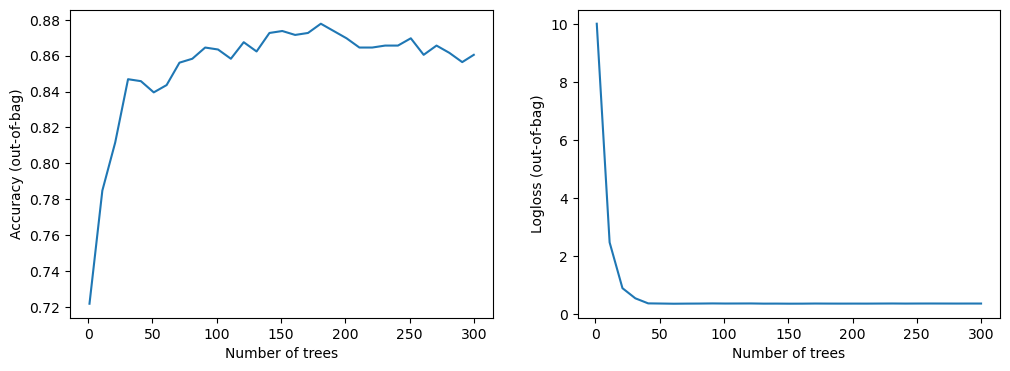


Train: nan Validation: 0.3015
##### Fold 2
Use /tmp/tmp6d9ppvaa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.012134. Found 555 examples.
Training model...
Model trained in 0:00:00.223812
Compiling model...


[INFO 23-07-20 08:50:50.8067 UTC kernel.cc:1242] Loading model from path /tmp/tmp6d9ppvaa/model/ with prefix c090c8c32bf84c59
[INFO 23-07-20 08:50:50.8426 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10330 node(s), and 113 input feature(s).
[INFO 23-07-20 08:50:50.8427 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 352ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3116


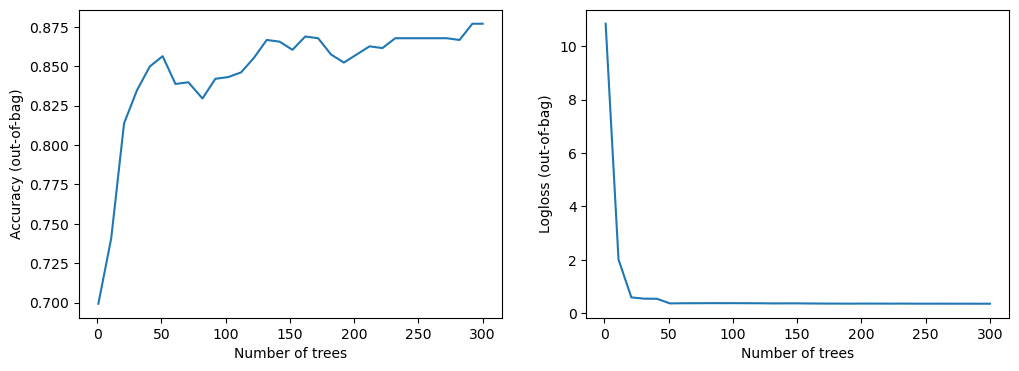


Train: nan Validation: 0.3116
##### Fold 3
Use /tmp/tmpd8exvsso as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.034104. Found 555 examples.
Training model...
Model trained in 0:00:00.278821
Compiling model...


[INFO 23-07-20 08:50:56.9385 UTC kernel.cc:1242] Loading model from path /tmp/tmpd8exvsso/model/ with prefix 3d7adeba76af42ea
[INFO 23-07-20 08:50:56.9746 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10300 node(s), and 112 input feature(s).
[INFO 23-07-20 08:50:56.9749 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:50:56.9750 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 341ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4417


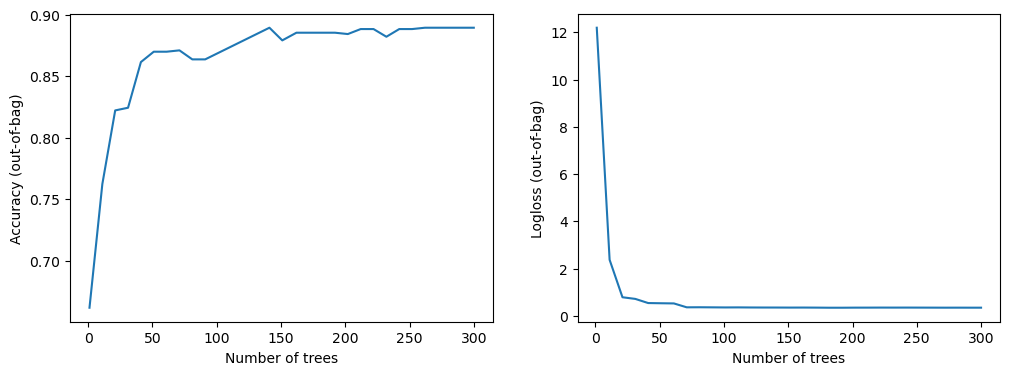


Train: nan Validation: 0.4417
##### Fold 4
Use /tmp/tmpsv7oxm93 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.913982. Found 555 examples.
Training model...
Model trained in 0:00:00.227337
Compiling model...


[INFO 23-07-20 08:51:02.8476 UTC kernel.cc:1242] Loading model from path /tmp/tmpsv7oxm93/model/ with prefix 350055bdf10e4a41
[INFO 23-07-20 08:51:02.8835 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10264 node(s), and 111 input feature(s).
[INFO 23-07-20 08:51:02.8837 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 340ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3305


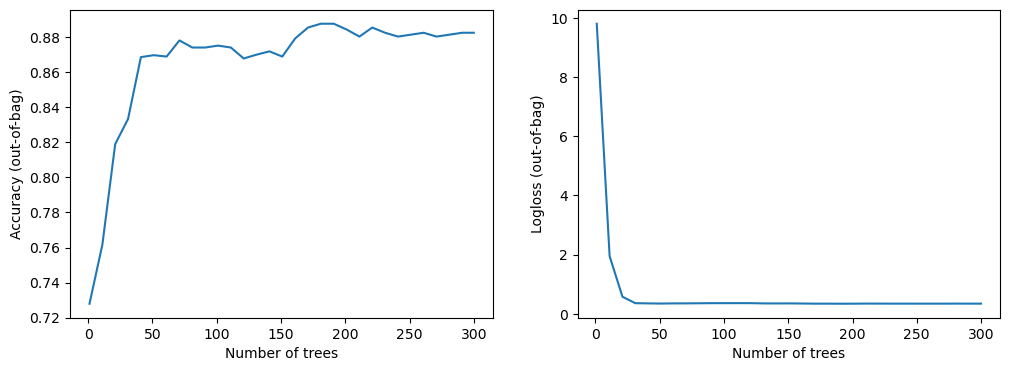


Train: nan Validation: 0.3305
##### Fold 5
Use /tmp/tmpsxl4sgrk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.920395. Found 555 examples.
Training model...
Model trained in 0:00:00.224231
Compiling model...


[INFO 23-07-20 08:51:08.7975 UTC kernel.cc:1242] Loading model from path /tmp/tmpsxl4sgrk/model/ with prefix a4a0ee6885ee4564
[INFO 23-07-20 08:51:08.8329 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10450 node(s), and 112 input feature(s).
[INFO 23-07-20 08:51:08.8330 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:51:08.8330 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 342ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3279


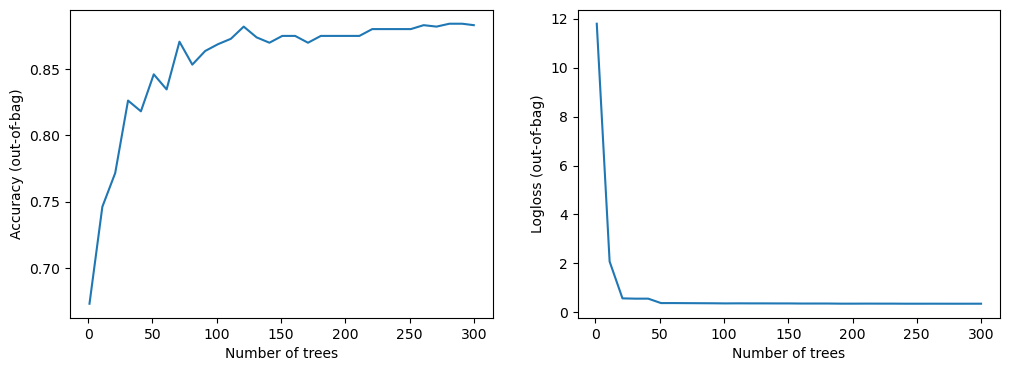


Train: nan Validation: 0.3279
##### Fold 6
Use /tmp/tmpklbmnqhy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.911122. Found 555 examples.
Training model...
Model trained in 0:00:00.227313
Compiling model...


[INFO 23-07-20 08:51:14.7164 UTC kernel.cc:1242] Loading model from path /tmp/tmpklbmnqhy/model/ with prefix 83b3def2ced040b8
[INFO 23-07-20 08:51:14.7520 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10332 node(s), and 112 input feature(s).
[INFO 23-07-20 08:51:14.7520 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 349ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


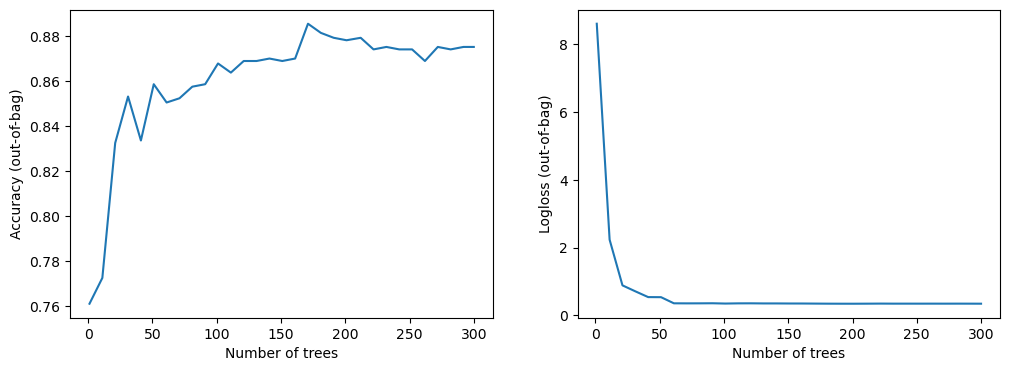


Train: nan Validation: nan
##### Fold 7
Use /tmp/tmpd39i3g8v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.918056. Found 555 examples.
Training model...
Model trained in 0:00:00.225559
Compiling model...


[INFO 23-07-20 08:51:21.9281 UTC kernel.cc:1242] Loading model from path /tmp/tmpd39i3g8v/model/ with prefix e08f2ad0c3454390
[INFO 23-07-20 08:51:21.9637 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10312 node(s), and 112 input feature(s).
[INFO 23-07-20 08:51:21.9638 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:51:21.9638 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 342ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4016


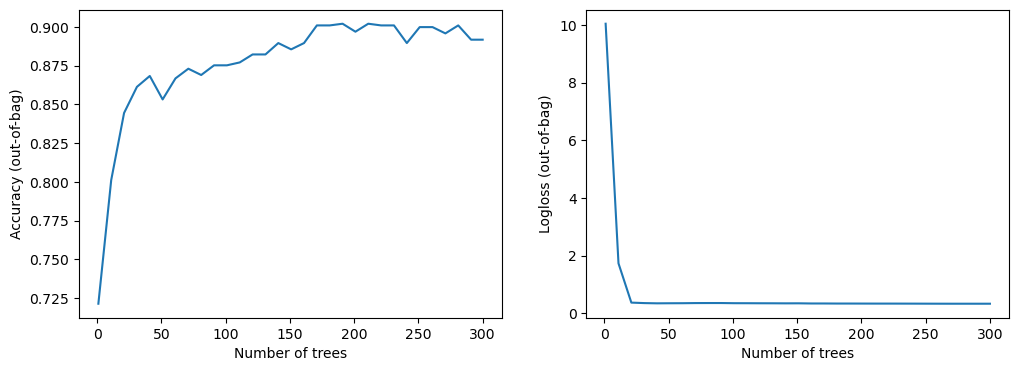


Train: nan Validation: 0.4016
##### Fold 8
Use /tmp/tmpn9lavuuq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.014154. Found 556 examples.
Training model...
Model trained in 0:00:00.308550
Compiling model...


[INFO 23-07-20 08:51:28.0149 UTC kernel.cc:1242] Loading model from path /tmp/tmpn9lavuuq/model/ with prefix 1e7c498c7f1b48dc
[INFO 23-07-20 08:51:28.0664 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10334 node(s), and 112 input feature(s).
[INFO 23-07-20 08:51:28.0666 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 344ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3344


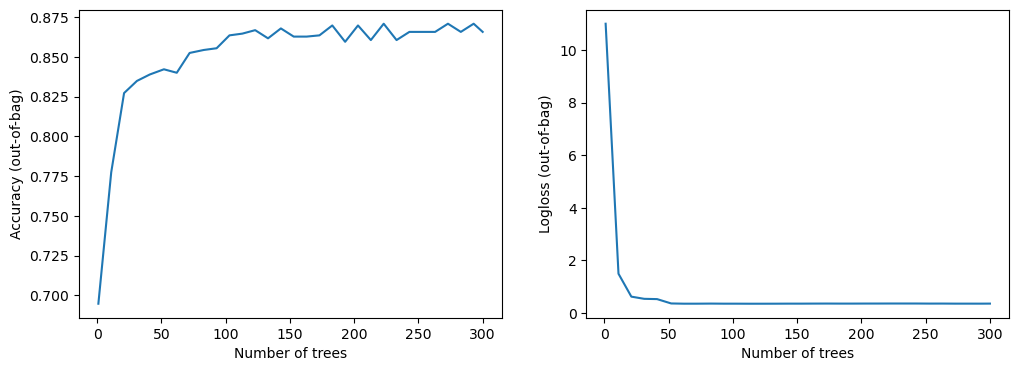


Train: nan Validation: 0.3344
##### Fold 9
Use /tmp/tmprjxq77wt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.928221. Found 556 examples.
Training model...
Model trained in 0:00:00.224304
Compiling model...


[INFO 23-07-20 08:51:33.9470 UTC kernel.cc:1242] Loading model from path /tmp/tmprjxq77wt/model/ with prefix f7ea6856ce704487
[INFO 23-07-20 08:51:33.9823 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10174 node(s), and 112 input feature(s).
[INFO 23-07-20 08:51:33.9823 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:51:33.9824 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 343ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4160


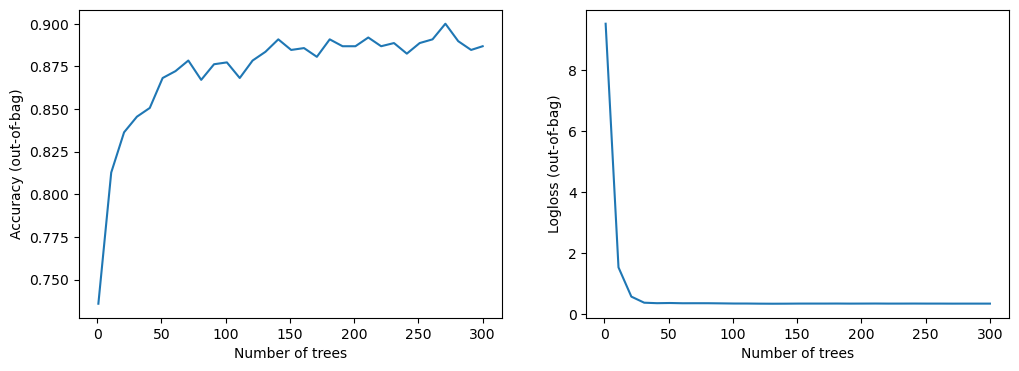


Train: nan Validation: 0.4160
##### Fold 10
Use /tmp/tmpmqvvykf3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.912813. Found 556 examples.
Training model...
Model trained in 0:00:00.226543
Compiling model...


[INFO 23-07-20 08:51:39.9118 UTC kernel.cc:1242] Loading model from path /tmp/tmpmqvvykf3/model/ with prefix 3450af618069454a
[INFO 23-07-20 08:51:39.9473 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10428 node(s), and 112 input feature(s).
[INFO 23-07-20 08:51:39.9474 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 344ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2804


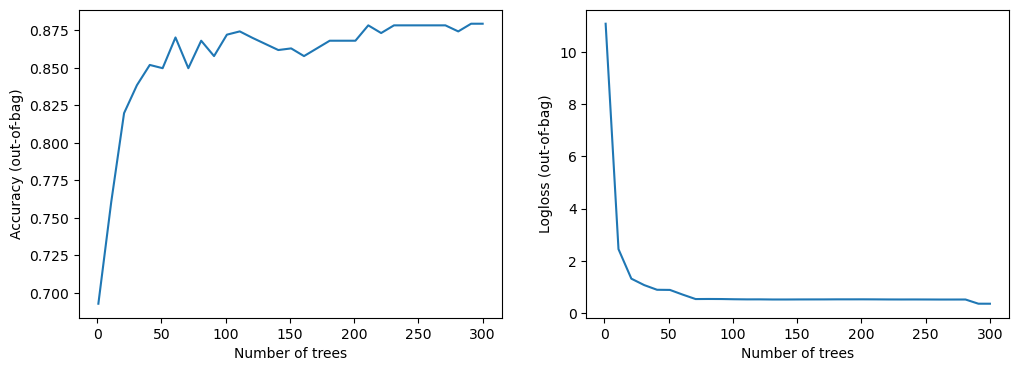


Train: nan Validation: 0.2804

Train mean: nan std: nan

Validation mean: 0.3495 std: 0.0561


In [50]:
# RandomForestModel
submition_rf_2, model_rf_2,metrics_rf_2 = train_model(
    train=train_out,test=test_out, features=features,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp8eiyao3c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.158418. Found 555 examples.
Training model...
Model trained in 0:00:00.176778
Compiling model...


[INFO 23-07-20 08:51:44.9872 UTC kernel.cc:1242] Loading model from path /tmp/tmp8eiyao3c/model/ with prefix f8ee1a23c5e6439d
[INFO 23-07-20 08:51:45.0263 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-20 08:51:45.0263 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:51:45.0264 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 247ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2470


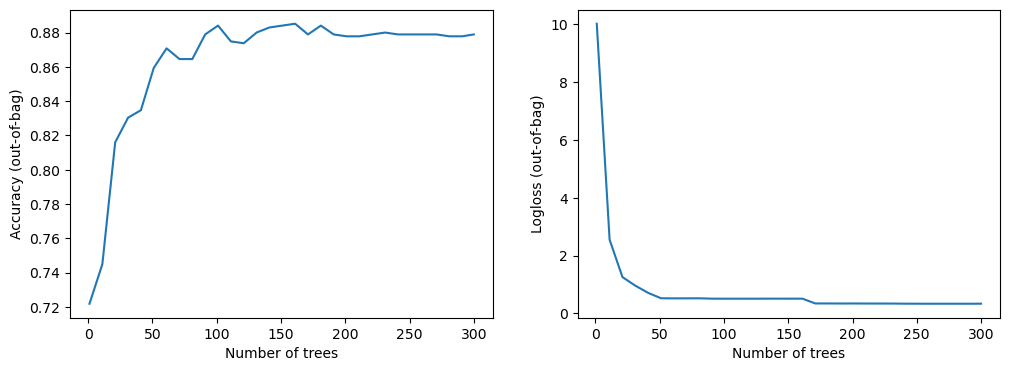


Train: nan Validation: 0.2470
##### Fold 2
Use /tmp/tmp5uv5_yor as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.186212. Found 555 examples.
Training model...
Model trained in 0:00:00.180436
Compiling model...


[INFO 23-07-20 08:51:49.0437 UTC kernel.cc:1242] Loading model from path /tmp/tmp5uv5_yor/model/ with prefix 3a4a8659c273425a
[INFO 23-07-20 08:51:49.0818 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-20 08:51:49.0819 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 249ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2757


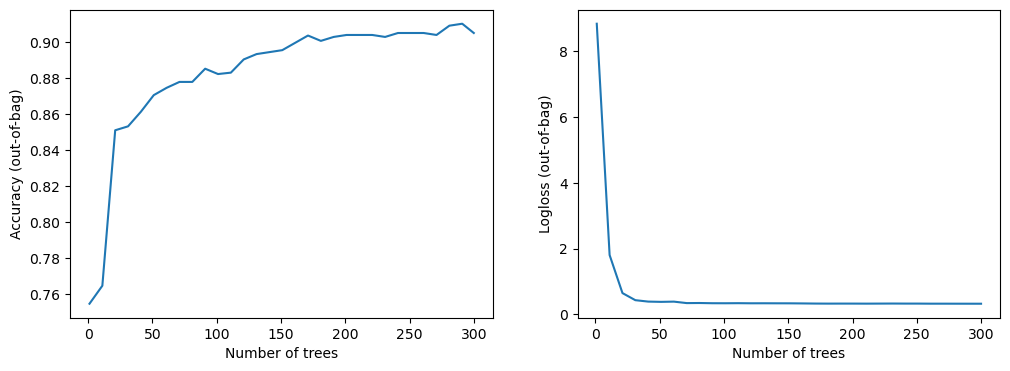


Train: nan Validation: 0.2757
##### Fold 3
Use /tmp/tmpaga9h1_e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.195240. Found 555 examples.
Training model...
Model trained in 0:00:00.175980
Compiling model...


[INFO 23-07-20 08:51:53.0378 UTC kernel.cc:1242] Loading model from path /tmp/tmpaga9h1_e/model/ with prefix 21c0a03d1d6348cd
[INFO 23-07-20 08:51:53.0759 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-20 08:51:53.0760 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 259ms/step - loss: 0.0000e+00 - accuracy: 0.0323 - balanced_logloss_tf: nan


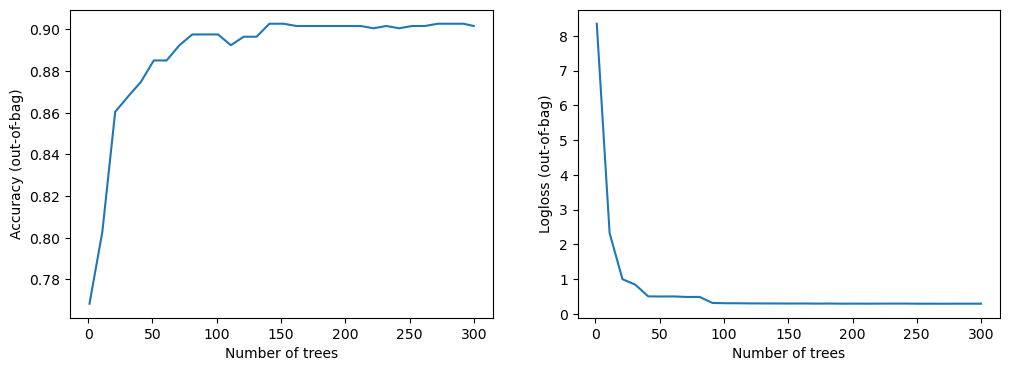


Train: nan Validation: nan
##### Fold 4
Use /tmp/tmp5nax2zsk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.209160. Found 555 examples.
Training model...
Model trained in 0:00:00.181407
Compiling model...


[INFO 23-07-20 08:51:57.0606 UTC kernel.cc:1242] Loading model from path /tmp/tmp5nax2zsk/model/ with prefix 02166811ae8a4e27
[INFO 23-07-20 08:51:57.0983 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-20 08:51:57.0983 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:51:57.0984 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 276ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


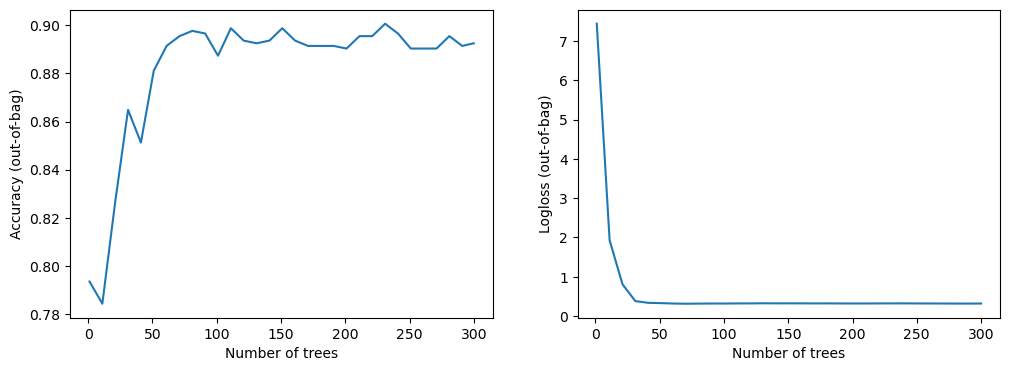


Train: nan Validation: nan
##### Fold 5
Use /tmp/tmp8o4ny66l as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.189160. Found 555 examples.
Training model...
Model trained in 0:00:00.180274
Compiling model...


[INFO 23-07-20 08:52:01.0912 UTC kernel.cc:1242] Loading model from path /tmp/tmp8o4ny66l/model/ with prefix 74fc2bb8d8e84188
[INFO 23-07-20 08:52:01.1294 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-20 08:52:01.1295 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 249ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


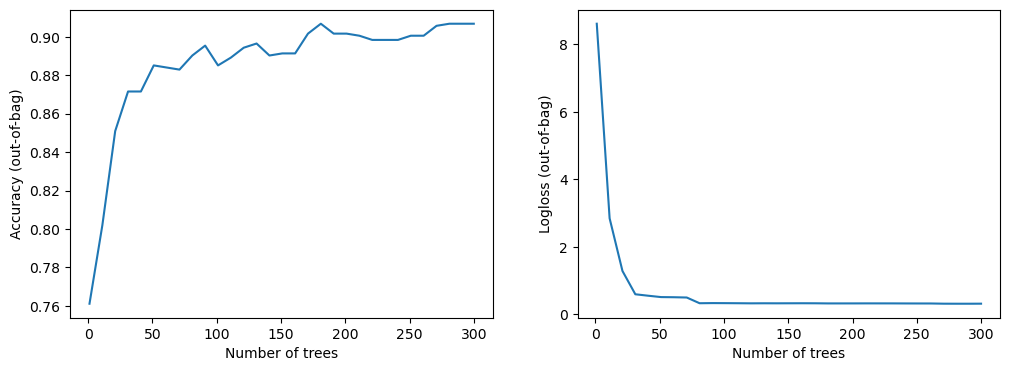


Train: nan Validation: nan
##### Fold 6
Use /tmp/tmpwaif7b3d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.184296. Found 555 examples.
Training model...
Model trained in 0:00:00.179767
Compiling model...


[INFO 23-07-20 08:52:05.0674 UTC kernel.cc:1242] Loading model from path /tmp/tmpwaif7b3d/model/ with prefix b24f0e302e664666
[INFO 23-07-20 08:52:05.1066 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-20 08:52:05.1067 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


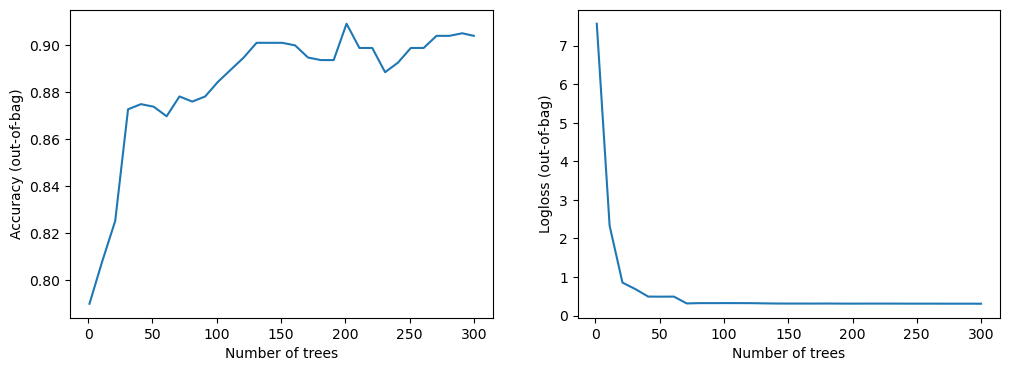


Train: nan Validation: nan
##### Fold 7
Use /tmp/tmpczb6wxip as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.217018. Found 555 examples.
Training model...
Model trained in 0:00:00.177411
Compiling model...


[INFO 23-07-20 08:52:09.5898 UTC kernel.cc:1242] Loading model from path /tmp/tmpczb6wxip/model/ with prefix 3d2a435f4b9e4c05
[INFO 23-07-20 08:52:09.6279 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-20 08:52:09.6280 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:52:09.6280 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 262ms/step - loss: 0.0000e+00 - accuracy: 0.0161 - balanced_logloss_tf: nan


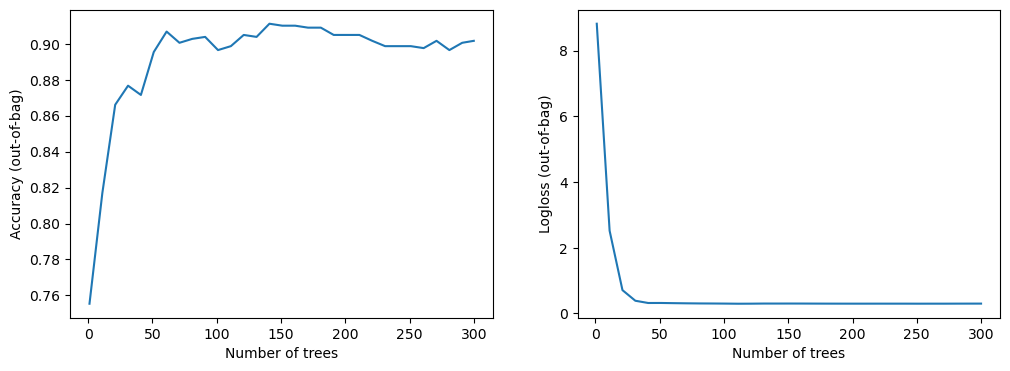


Train: nan Validation: nan
##### Fold 8
Use /tmp/tmp6b63o8og as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.187378. Found 556 examples.
Training model...
Model trained in 0:00:00.177827
Compiling model...


[INFO 23-07-20 08:52:14.0909 UTC kernel.cc:1242] Loading model from path /tmp/tmp6b63o8og/model/ with prefix 65c1ee2413554cc8
[INFO 23-07-20 08:52:14.1296 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-20 08:52:14.1297 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 247ms/step - loss: 0.0000e+00 - accuracy: 0.0328 - balanced_logloss_tf: nan


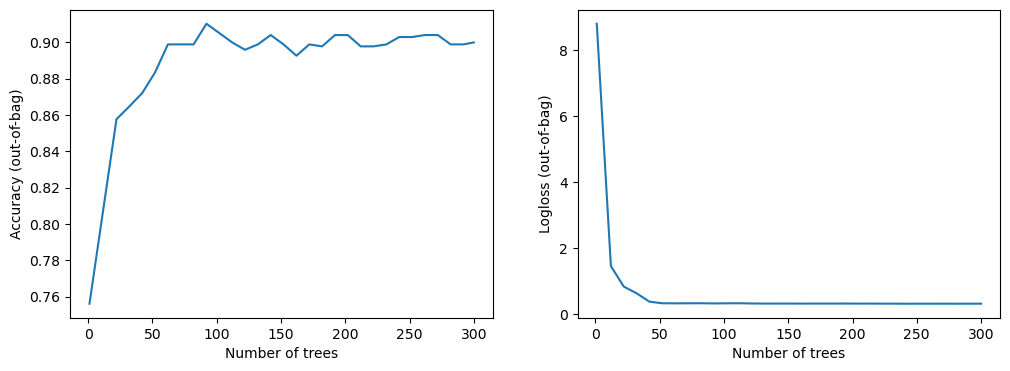


Train: nan Validation: nan
##### Fold 9
Use /tmp/tmpysutzd1h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.195696. Found 556 examples.
Training model...
Model trained in 0:00:00.177527
Compiling model...


[INFO 23-07-20 08:52:20.5991 UTC kernel.cc:1242] Loading model from path /tmp/tmpysutzd1h/model/ with prefix f5ff9f454b6a454e
[INFO 23-07-20 08:52:20.6404 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-20 08:52:20.6406 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 08:52:20.6407 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 252ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3449


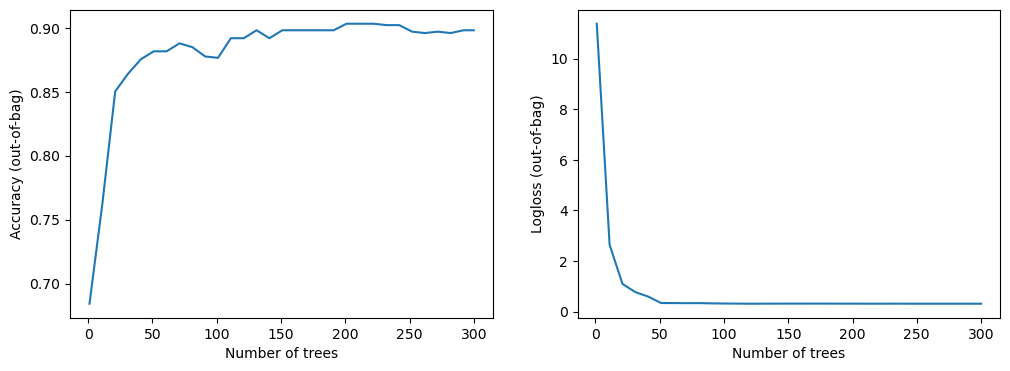


Train: nan Validation: 0.3449
##### Fold 10
Use /tmp/tmpuh14kois as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.185528. Found 556 examples.
Training model...
Model trained in 0:00:00.175607
Compiling model...


[INFO 23-07-20 08:52:24.6115 UTC kernel.cc:1242] Loading model from path /tmp/tmpuh14kois/model/ with prefix 04706e70f1264c9d
[INFO 23-07-20 08:52:24.6498 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-20 08:52:24.6499 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 252ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2687


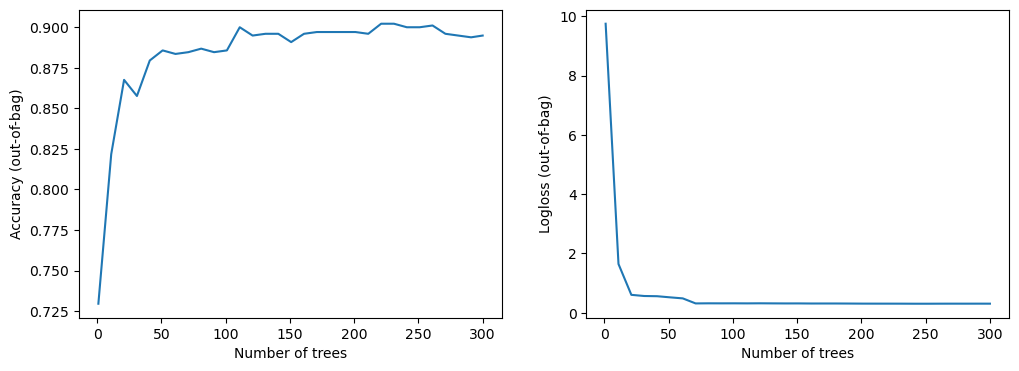


Train: nan Validation: 0.2687

Train mean: nan std: nan

Validation mean: 0.2840 std: 0.0423


In [51]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

submition_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

# GradientBoostedTreesModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpa820paz7 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:52:27.3847 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:27.3848 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:27.3848 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.193491. Found 555 examples.
Training model...
Model trained in 0:00:01.866603
Compiling model...


[INFO 23-07-20 08:52:30.4378 UTC kernel.cc:1242] Loading model from path /tmp/tmpa820paz7/model/ with prefix 0a1cc4dc92944330
[INFO 23-07-20 08:52:30.4560 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 255ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.0299


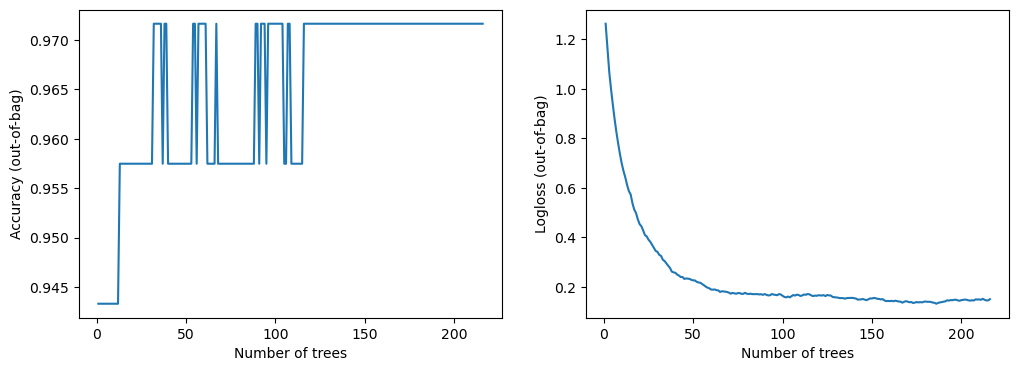


Train: 0.0060 Validation: 0.0299
##### Fold 2
Use /tmp/tmpmhx4k9oj as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:52:33.0939 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:33.0939 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:33.0939 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.207893. Found 555 examples.
Training model...
Model trained in 0:00:01.726970
Compiling model...


[INFO 23-07-20 08:52:36.0217 UTC kernel.cc:1242] Loading model from path /tmp/tmpmhx4k9oj/model/ with prefix d5305e2cf8f84b77
[INFO 23-07-20 08:52:36.0378 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 08:52:36.0378 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 251ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1438


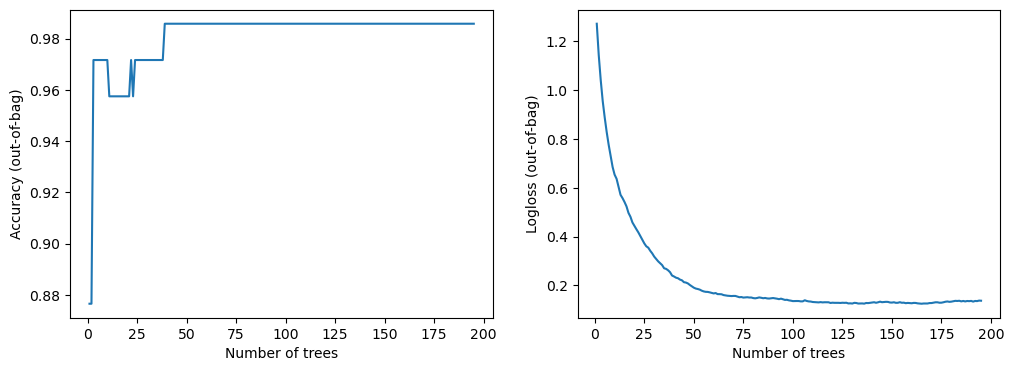


Train: 0.0060 Validation: 0.1438
##### Fold 3
Use /tmp/tmphwoe7gew as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:52:38.7109 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:38.7109 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:38.7109 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.206775. Found 555 examples.
Training model...
Model trained in 0:00:02.255265
Compiling model...


[INFO 23-07-20 08:52:42.1595 UTC kernel.cc:1242] Loading model from path /tmp/tmphwoe7gew/model/ with prefix 2276ae71ca854222
[INFO 23-07-20 08:52:42.1809 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 285ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.8838


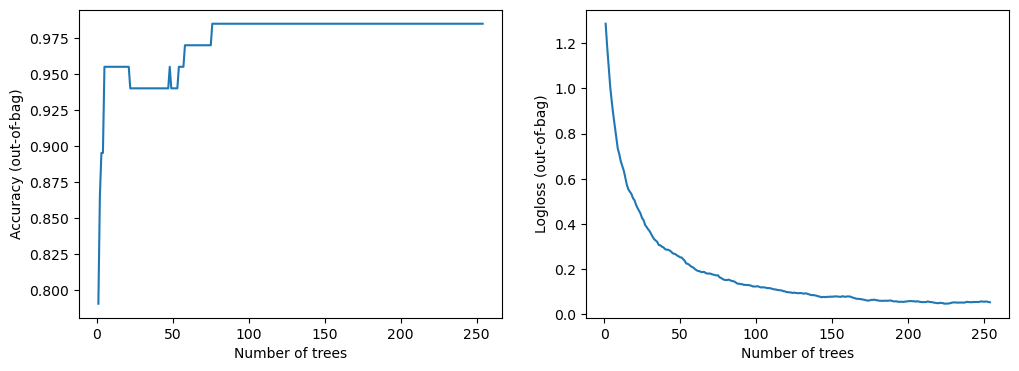


Train: 0.0019 Validation: 0.8838
##### Fold 4
Use /tmp/tmp9ds04595 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:52:47.0683 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:47.0683 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:47.0683 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.206062. Found 555 examples.
Training model...
Model trained in 0:00:02.278971
Compiling model...


[INFO 23-07-20 08:52:50.5383 UTC kernel.cc:1242] Loading model from path /tmp/tmp9ds04595/model/ with prefix 5cd25a7475594c3f
[INFO 23-07-20 08:52:50.5607 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 08:52:50.5608 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3553


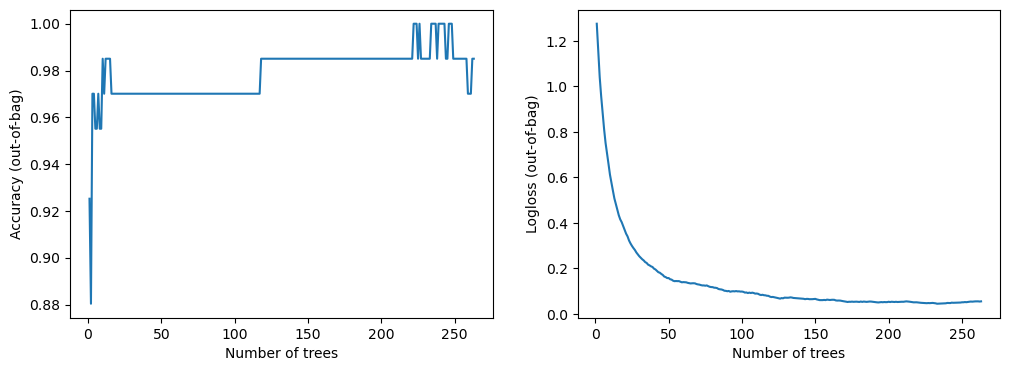


Train: 0.0018 Validation: 0.3553
##### Fold 5
Use /tmp/tmpqrgmeym1 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:52:53.1545 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:53.1546 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:53.1546 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.202429. Found 555 examples.
Training model...
Model trained in 0:00:02.420657
Compiling model...


[INFO 23-07-20 08:52:56.7619 UTC kernel.cc:1242] Loading model from path /tmp/tmpqrgmeym1/model/ with prefix be0c6674d7f94e5a
[INFO 23-07-20 08:52:56.7857 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 272ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.5371


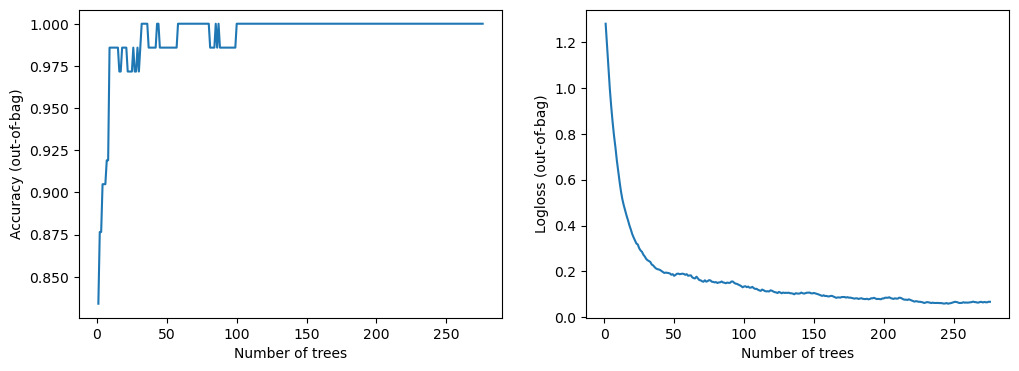


Train: 0.0024 Validation: 0.5371
##### Fold 6
Use /tmp/tmpj9e828t1 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:52:59.4397 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:59.4398 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:52:59.4399 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.220149. Found 555 examples.
Training model...
Model trained in 0:00:01.307752
Compiling model...


[INFO 23-07-20 08:53:01.9646 UTC kernel.cc:1242] Loading model from path /tmp/tmpj9e828t1/model/ with prefix 7542cb1bd5394a0c
[INFO 23-07-20 08:53:01.9759 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 08:53:01.9761 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2998


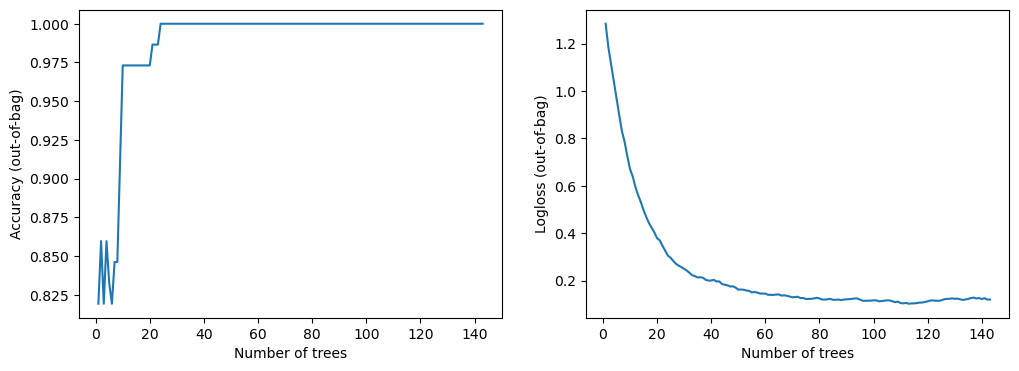


Train: 0.0096 Validation: 0.2998
##### Fold 7
Use /tmp/tmpz34uorpp as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:05.2302 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:05.2302 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:05.2302 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.223243. Found 555 examples.
Training model...
Model trained in 0:00:00.567192
Compiling model...


[INFO 23-07-20 08:53:07.0246 UTC kernel.cc:1242] Loading model from path /tmp/tmpz34uorpp/model/ with prefix 5abe1306b6f742cd
[INFO 23-07-20 08:53:07.0287 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 253ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3052


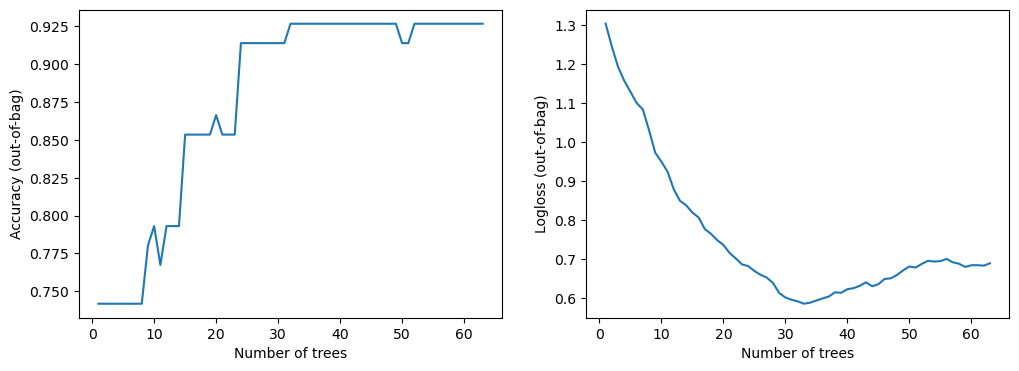


Train: 0.1055 Validation: 0.3052
##### Fold 8
Use /tmp/tmpzviqgdb1 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:09.6368 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:09.6368 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:09.6368 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.227951. Found 556 examples.
Training model...
Model trained in 0:00:00.599381
Compiling model...


[INFO 23-07-20 08:53:11.4684 UTC kernel.cc:1242] Loading model from path /tmp/tmpzviqgdb1/model/ with prefix 1518573ae2c0490c
[INFO 23-07-20 08:53:11.4725 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 256ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3190


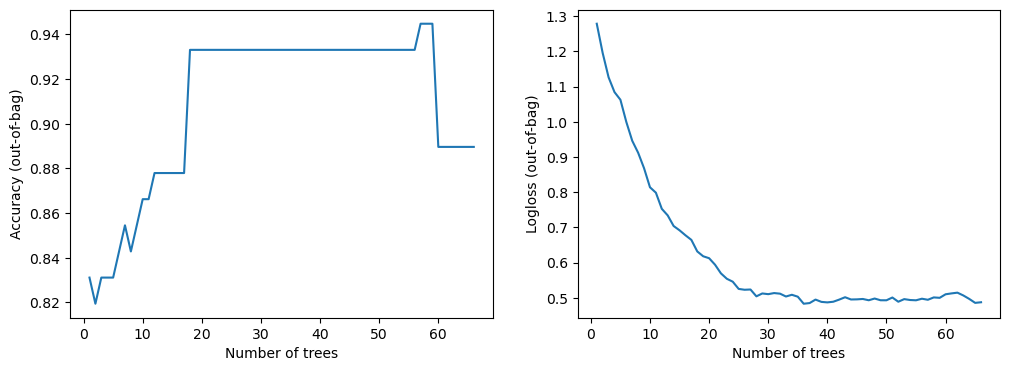


Train: 0.0954 Validation: 0.3190
##### Fold 9
Use /tmp/tmpchxc2h0j as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:14.1026 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:14.1026 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:14.1026 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.200883. Found 556 examples.
Training model...
Model trained in 0:00:00.916788
Compiling model...


[INFO 23-07-20 08:53:16.2245 UTC kernel.cc:1242] Loading model from path /tmp/tmpchxc2h0j/model/ with prefix 739cfd8b45bf4b07
[INFO 23-07-20 08:53:16.2317 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 08:53:16.2317 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 249ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.4456


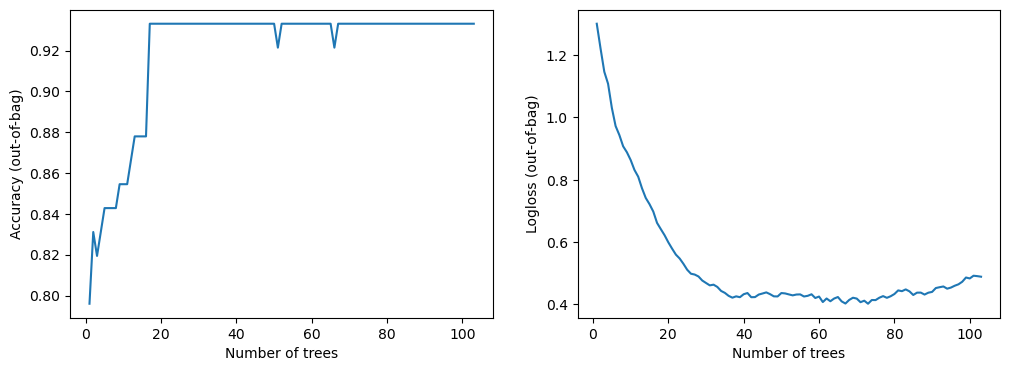


Train: 0.0349 Validation: 0.4456
##### Fold 10
Use /tmp/tmpl6j_7mt0 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:18.8202 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:18.8203 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:18.8203 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.210081. Found 556 examples.
Training model...
Model trained in 0:00:00.577397
Compiling model...


[INFO 23-07-20 08:53:20.6123 UTC kernel.cc:1242] Loading model from path /tmp/tmpl6j_7mt0/model/ with prefix 58259fb61c36461b
[INFO 23-07-20 08:53:20.6162 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 246ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2912


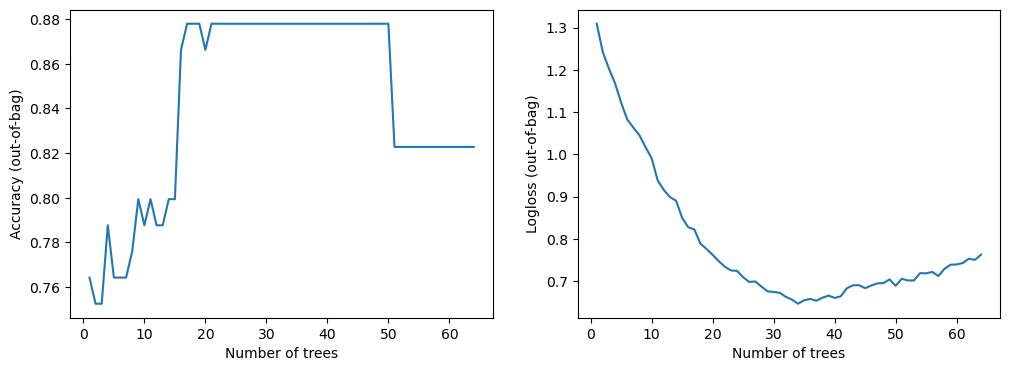


Train: 0.1098 Validation: 0.2912

Train mean: 0.0373 std: 0.0469

Validation mean: 0.3611 std: 0.2314


In [52]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

submition_gbt_1, model_gbt_1,metrics_gbt_1 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpkdu4_vtx as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:23.2920 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:23.2920 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:23.2920 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.186711. Found 555 examples.
Training model...
Model trained in 0:00:00.991092
Compiling model...


[INFO 23-07-20 08:53:25.4684 UTC kernel.cc:1242] Loading model from path /tmp/tmpkdu4_vtx/model/ with prefix 63e034052b2646f2
[INFO 23-07-20 08:53:25.4770 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 249ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1640


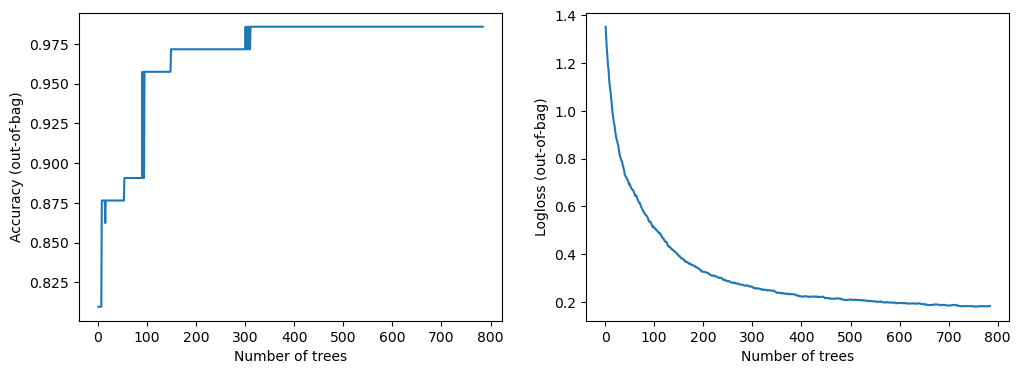


Train: 0.1127 Validation: 0.1640
##### Fold 2
Use /tmp/tmpvjjl8f5u as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:28.1468 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:28.1469 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:28.1469 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.221455. Found 555 examples.
Training model...
Model trained in 0:00:00.610648
Compiling model...


[INFO 23-07-20 08:53:29.9818 UTC kernel.cc:1242] Loading model from path /tmp/tmpvjjl8f5u/model/ with prefix 24166abaa7914f2a
[INFO 23-07-20 08:53:29.9875 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 08:53:29.9876 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1576


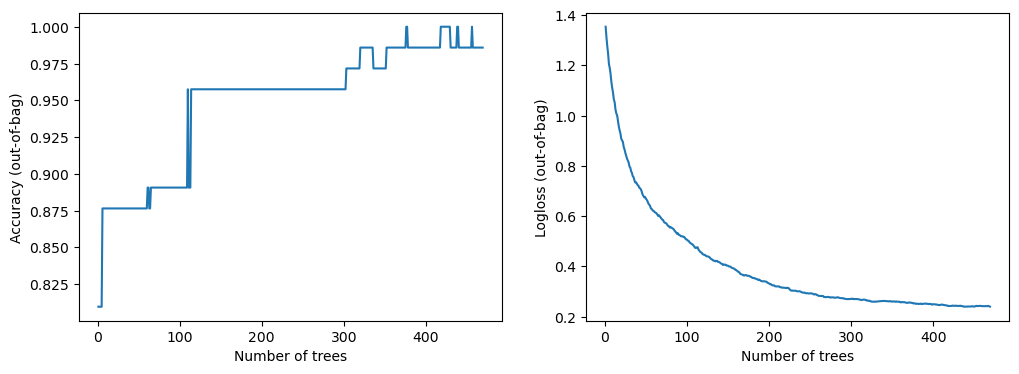


Train: 0.1418 Validation: 0.1576
##### Fold 3
Use /tmp/tmpk7id12d8 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:32.5902 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:32.5902 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:32.5902 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.257039. Found 555 examples.
Training model...
Model trained in 0:00:00.728586
Compiling model...


[INFO 23-07-20 08:53:34.5791 UTC kernel.cc:1242] Loading model from path /tmp/tmpk7id12d8/model/ with prefix bfaca6fcf64843c4
[INFO 23-07-20 08:53:34.5856 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 251ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3384


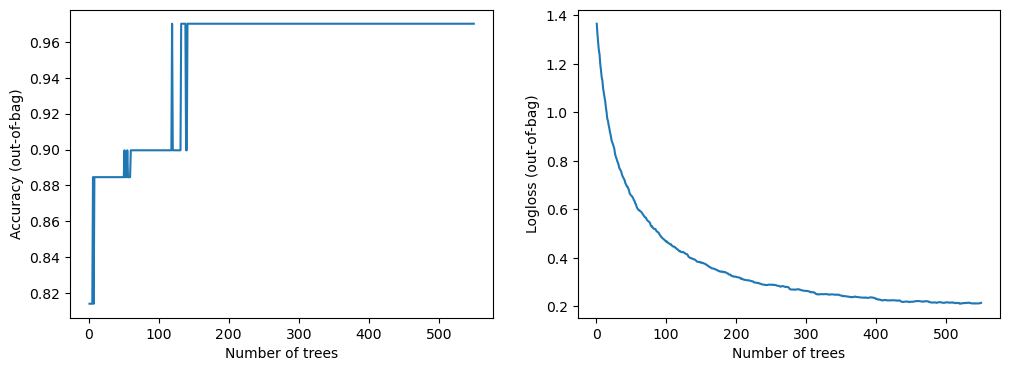


Train: 0.1189 Validation: 0.3384
##### Fold 4
Use /tmp/tmprl0pot_v as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:38.4381 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:38.4381 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:38.4381 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.223265. Found 555 examples.
Training model...
Model trained in 0:00:00.603184
Compiling model...


[INFO 23-07-20 08:53:40.2694 UTC kernel.cc:1242] Loading model from path /tmp/tmprl0pot_v/model/ with prefix 21e7b964ec8a45a7
[INFO 23-07-20 08:53:40.2750 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 08:53:40.2750 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 257ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2671


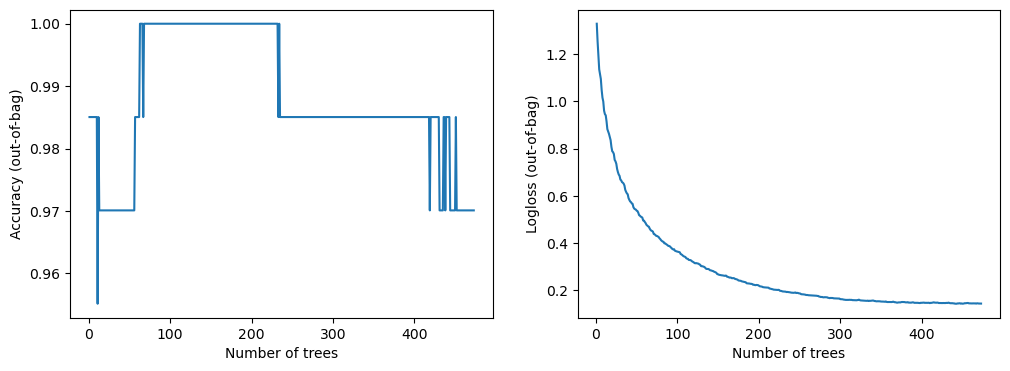


Train: 0.1329 Validation: 0.2671
##### Fold 5
Use /tmp/tmp0djok1ri as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:42.8780 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:42.8780 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:42.8780 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.244936. Found 555 examples.
Training model...
Model trained in 0:00:00.929888
Compiling model...


[INFO 23-07-20 08:53:45.0541 UTC kernel.cc:1242] Loading model from path /tmp/tmp0djok1ri/model/ with prefix 26d316537f6840f6
[INFO 23-07-20 08:53:45.0630 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 260ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2613


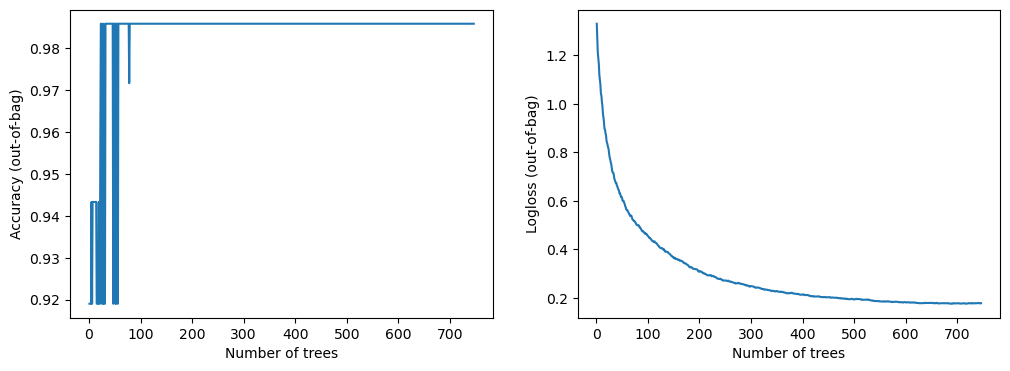


Train: 0.1059 Validation: 0.2613
##### Fold 6
Use /tmp/tmpjfymhbcy as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:47.7241 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:47.7241 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:47.7241 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.241119. Found 555 examples.
Training model...
Model trained in 0:00:01.077018
Compiling model...


[INFO 23-07-20 08:53:50.0401 UTC kernel.cc:1242] Loading model from path /tmp/tmpjfymhbcy/model/ with prefix ff285ba343c74b98
[INFO 23-07-20 08:53:50.0502 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 247ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2744


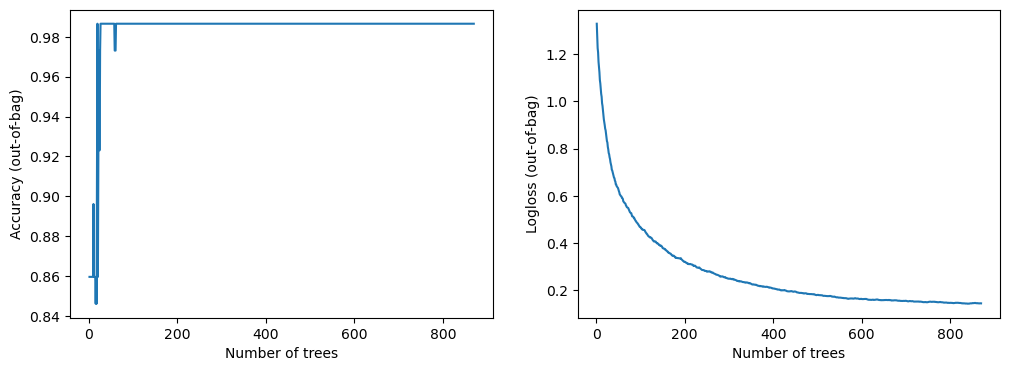


Train: 0.0958 Validation: 0.2744
##### Fold 7
Use /tmp/tmpnm2gbg99 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:52.6332 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:52.6332 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:52.6333 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.214869. Found 555 examples.
Training model...
Model trained in 0:00:00.491300
Compiling model...


[INFO 23-07-20 08:53:54.3428 UTC kernel.cc:1242] Loading model from path /tmp/tmpnm2gbg99/model/ with prefix 9c64fe88d4cc4811
[INFO 23-07-20 08:53:54.3476 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 08:53:54.3477 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2420


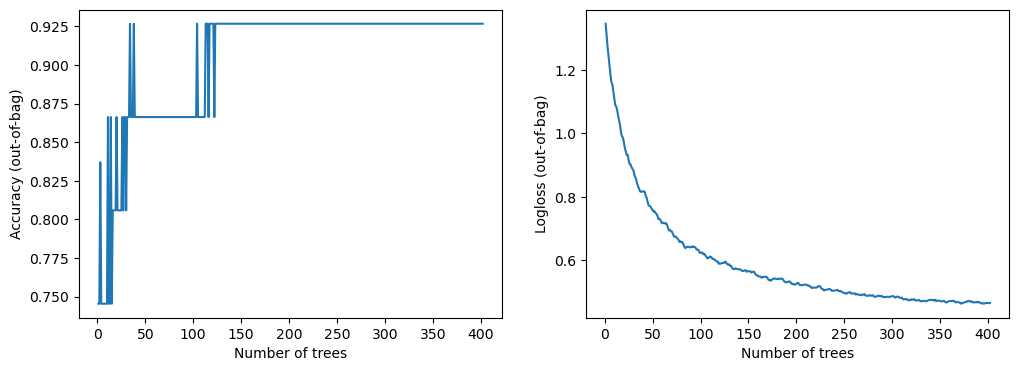


Train: 0.1518 Validation: 0.2420
##### Fold 8
Use /tmp/tmpukwdsd9w as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:53:56.9992 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:56.9994 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:53:56.9996 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.214654. Found 556 examples.
Training model...
Model trained in 0:00:00.519791
Compiling model...


[INFO 23-07-20 08:53:58.7370 UTC kernel.cc:1242] Loading model from path /tmp/tmpukwdsd9w/model/ with prefix be1569f04efd47da
[INFO 23-07-20 08:53:58.7423 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 252ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.2632


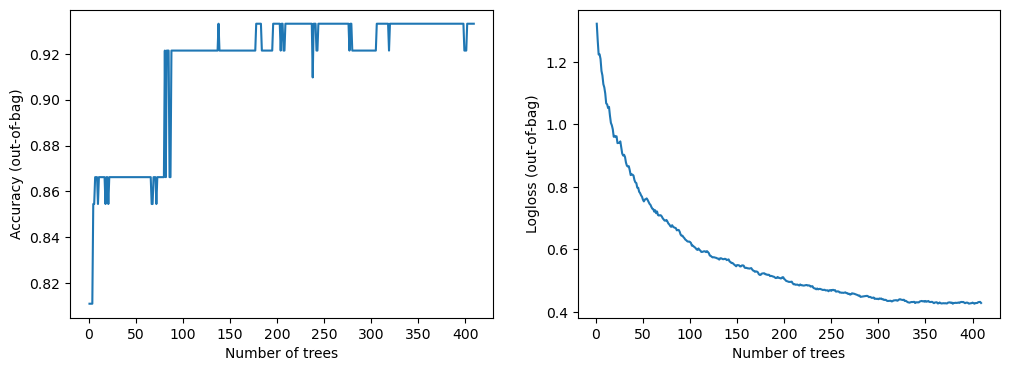


Train: 0.1428 Validation: 0.2632
##### Fold 9
Use /tmp/tmply99zuen as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:54:01.3542 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:54:01.3543 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:54:01.3543 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.234194. Found 556 examples.
Training model...
Model trained in 0:00:00.684458
Compiling model...


[INFO 23-07-20 08:54:03.2749 UTC kernel.cc:1242] Loading model from path /tmp/tmply99zuen/model/ with prefix 46dd088ad2934d3e
[INFO 23-07-20 08:54:03.2818 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 261ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.3122


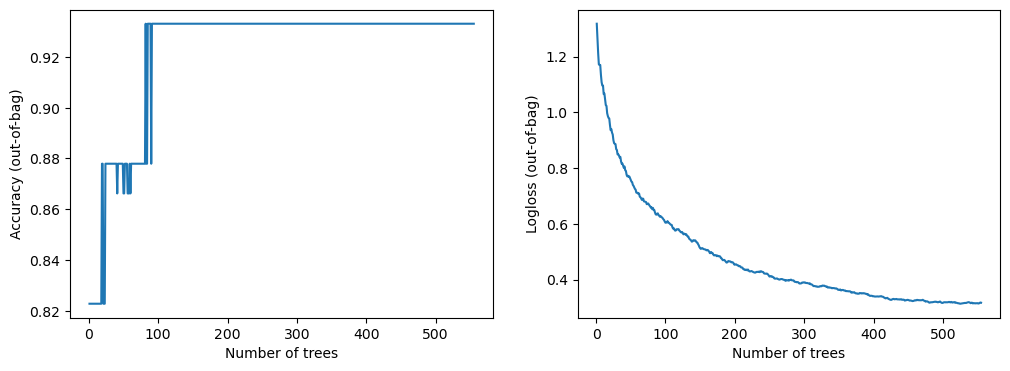


Train: 0.1171 Validation: 0.3122
##### Fold 10
Use /tmp/tmpietcwe20 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 08:54:05.9477 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:54:05.9478 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 08:54:05.9478 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.241242. Found 556 examples.
Training model...
Model trained in 0:00:00.564291
Compiling model...


[INFO 23-07-20 08:54:07.7559 UTC kernel.cc:1242] Loading model from path /tmp/tmpietcwe20/model/ with prefix 6bc6abc899424b7e
[INFO 23-07-20 08:54:07.7612 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 08:54:07.7613 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 247ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - balanced_logloss_tf: 0.1399


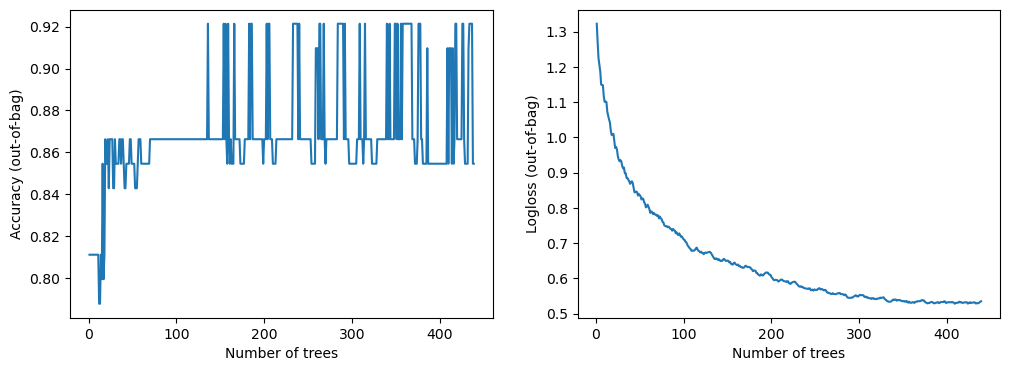


Train: 0.1509 Validation: 0.1399

Train mean: 0.1271 std: 0.0197

Validation mean: 0.2420 std: 0.0670


In [53]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

submition_gbt_2, model_gbt_2,metrics_gbt_2 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.accuracy, balanced_logloss_tf]))

# TabPFN

In [54]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

In [55]:
def train_model_tabpfn_one(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    submition_df = pd.DataFrame(data=np.zeros((len(submition.index),1)),index=submition.index)
    train_df_out = pd.DataFrame(data=np.zeros((len(train.index),1)),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_sub = model.predict_proba(submition[features])[:,1]

    # Predict value for validation/Submition data
    submition_df[0] = p_sub.flatten() 
    train_df_out[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
            
    # metrics['accuracy'] = accuracy_score(train_df[label].values, p_train)
    train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    metrics['balanced_logloss'] = train_metric
    print(f"\nTrain: {train_metric:.4f}")
    
            
    return train_df_out,submition_df,model,metrics

In [56]:

def train_model_tabpfn_cv(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    # out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition_out = pd.DataFrame(data=np.zeros((len(submition.index),n_splits)),index=submition.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # Define & Train the model
            model = TabPFNClassifier(N_ensemble_configurations=64)
            model.fit(train_df[features],train_df[label])

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            p_train = model.predict_proba(train_df[features])[:,1]
            p_val = model.predict_proba(valid_df[features])[:,1]
            p_sub = model.predict_proba(submition[features])[:,1]
            
            # out_of_fold.loc[valid_ids, 0] = p_val
            submition_out[i] = p_sub

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[label].values,y_pred=p_val)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
            
    return submition,models,metrics

In [57]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
train_tabpfn_1, submition_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
    train=train_out,submition=test_out, features=features_slice)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515


In [43]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
submition_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,submition=test_out, features=features_slice, n_splits=6)

##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0559 Validation: 0.1706
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0553 Validation: 0.2929
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0538 Validation: 0.2968
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0448 Validation: 0.1985
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0518 Validation: 0.4682
##### Fold 6
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.1178

Train mean: 0.0521 std: 0.0040

Validation mean: 0.2575 std: 0.1247


# Submission

In [119]:
# Aggragate Subs

# RF
RF_m = pd.Series(metrics_1['balanced_logloss']).mean()
TabPFN_m = pd.Series(metrics_2).mean()

print('RF: metric ', RF_m)
print('TabPFN: metric ', TabPFN_m)

RF_w = 1-(RF_m/(RF_m+TabPFN_m))
TabPFN_w = 1-(TabPFN_m/(RF_m+TabPFN_m))

print('RF weight: ', RF_w)
print('TabPFN weight: ', TabPFN_w)

submition_total = pd.concat([submition_1.mean(axis=1).to_frame(),submition_2], axis=1)
submition_total.columns = ['RF','TabPFN']

submition_total['Ensemble'] = RF_w*submition_total['RF'] + TabPFN_w*submition_total['TabPFN']

# submition_total

submition_total = submition_total[['Ensemble']].copy()

submition_total.columns = ['class_1']

submition_total['class_0'] = 1 - submition_total['class_1']

RF: metric  0.34483136236667633
TabPFN: metric  0.05152794842815339
RF weight:  0.13000312349121568
TabPFN weight:  0.8699968765087843


In [117]:
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

,class_1,class_0
Id,,
00eed32682bb,0.620704,0.379296
010ebe33f668,0.620704,0.379296
02fa521e1838,0.620704,0.379296
040e15f562a2,0.620704,0.379296
046e85c7cc7f,0.620704,0.379296
